In [1]:
import ROOT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep

In [2]:
%%script false --no raise error
# Read files
with open("ttbar_file_complete.txt", "r") as f:
    files = [line.strip() for line in f if line.strip()]
    
    
tree_name = "Events"
df = ROOT.RDataFrame(tree_name, files)
print("Total entries:", df.Count().GetValue())

In [3]:
file = 'ttbar.root'
df = ROOT.RDataFrame("Events", file)

Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


JEC

In [4]:
# Import correction files and a function to extract from the file
import correctionlib
correctionlib.register_pyroot_binding()

correction_file = "jet_jerc.json.gz"
correction = "Summer24Prompt24_V1_MC_L2Relative_AK4PFPuppi"

correction_variables = f"""
#include <iostream>
#include "correction.h"
auto cset = correction::CorrectionSet::from_file("{correction_file}");
auto evaluator = cset->at("{correction}");
"""

ROOT.gInterpreter.Declare(correction_variables)

True

In [5]:
# Function to apply JEC
correction_call = """
ROOT::VecOps::RVec<float> getCorrection(ROOT::VecOps::RVec<float> Jet_eta, ROOT::VecOps::RVec<float> Jet_phi, ROOT::VecOps::RVec<float> Jet_pt) {
    ROOT::VecOps::RVec<float> JECs;
    for (int i = 0; i < Jet_pt.size(); i++) {
        JECs.push_back(evaluator->evaluate({Jet_eta[i], Jet_phi[i], Jet_pt[i]}));
    }
    JECs = 1.0 - 1.0/JECs;
    return JECs;
}
"""

ROOT.gInterpreter.Declare(correction_call)

True

In [6]:
# Remove NanoAOD JEC and apply from correctionlib
df = (df.Define("Jet_rawpt", "(1.0 - Jet_rawFactor) * Jet_pt")
        .Define("Jet_clibFactor", "getCorrection(Jet_eta, Jet_phi, Jet_rawpt)")
        .Redefine("Jet_pt", " 1.0 / (1.0 - Jet_clibFactor) * Jet_rawpt")
     )

Reweighting

In [7]:
# Apply corrections for FSR
df = (df.Define("w_FSR_up",    "genWeight *  PSWeight[1]")
        .Define("w_FSR_down",  "genWeight *  PSWeight[3]"))

In [8]:
# Changed so that the keys are not needed, but here a list of saved values
# Names to rename extracted values without r-strings
semileptonic_keys = [r'$b \rightarrow \mu / e$', 
                     r'$b \rightarrow \tau \rightarrow \mu / e$',
                     r'$b \rightarrow c \rightarrow \mu / e$',
                     r'$b \rightarrow \bar{c} \rightarrow \mu / e$',
                     'Non Semileptonic',
                     'Intervals']

semileptonic_individual_keys = [r'$B^0 \rightarrow \mu / e$',
                                r'$B^\pm \rightarrow \mu / e$',
                                r'$B^0_s \rightarrow \mu / e$',
                                r'$\Lambda^0_s \rightarrow \mu / e$',
                                r'$B^0 \rightarrow \mu / e$'+ '_non_sl',
                                r'$B^\pm \rightarrow \mu / e$'+ '_non_sl',
                                r'$B^0_s \rightarrow \mu / e$'+ '_non_sl',
                                r'$\Lambda^0_s \rightarrow \mu / e$'+ '_non_sl',
                                'Intervals']


inclusive_decay_keys = [r'$B^0 \rightarrow D^0 / \bar{D}^0$',
                        r'$B^0 \rightarrow D^+ / D^-$',
                        r'$B^0 \rightarrow D^+_s / D^-_s$',
                        'OtherB0'
                        r'$B^+ \rightarrow D^0 / \bar{D}^0$',
                        r'$B^+ \rightarrow D^+ / D^-$',
                        r'$B^+ \rightarrow D^+_s / D^-_s$',
                        'OtherBp',
                        r'$B^0_s \rightarrow D^-_s$',
                        'Intervals']


production_fraction_keys = [r'$c_{0,s}$',
                             r'$c_{0s,m}$',
                             r'$c_{\Lambda_b,b}$',
                             'Intervals']


# Rename for the root environment without r strings
# names = ["sl_direct", "sl_tau", "sl_charm", "sl_anticharm", 'NonSemileptonic', 
#          "B0", "Bp", "Bs", "Lb", "B0H", "BpH", "BsH", "LbH", 
#          "B0Ds", "B0D0", "B0Dp", "OtherB0",
#          "BpDs", "BpD0", "BpDp", "OtherBp",
#          "BsDs", "OtherBs",
#          'c0s', 'c0sm', 'cLbb', 'Intervals']

names = ["sl_direct", "sl_tau", "sl_charm", "sl_anticharm", 'NonSemileptonic', 'Intervals',
         "B0", "Bp", "Bs", "Lb", "B0H", "BpH", "BsH", "LbH", 
         "B0Dp", "B0D0", "B0Ds", "OtherB0",
         "BpDp", "BpD0", "BpDs", "OtherBp",
         "BsDs", "OtherBs"]

names_variations = ["sl_direct", "sl_tau", "sl_charm", "sl_anticharm", 'NonSemileptonic',
         "B0", "Bp", "Bs", "Lb", "B0H", "BpH", "BsH", "LbH", 
         "B0Dp", "B0D0", "B0Ds", "OtherB0",
         "BpDp", "BpD0", "BpDs", "OtherBp",
         "BsDs", "OtherBs"]




In [9]:
# Collect values for scaling factors from the text file
restored_values = {}
with open('scaling_factors.txt', 'r') as f:
    for line in f:
        key, vals = line.strip().split(':')
        restored_values[key] = list(map(float, vals.split(',')))

print(list(restored_values.keys()))             # Should correspond to manually added keys

['$b \\rightarrow \\mu / e$', '$b \\rightarrow \\tau \\rightarrow \\mu / e$', '$b \\rightarrow c \\rightarrow \\mu / e$', '$b \\rightarrow \\bar{c} \\rightarrow \\mu / e$', 'Non semileptonic', 'Intervals', '$B^0 \\rightarrow \\mu / e$', '$B^\\pm \\rightarrow \\mu / e$', '$B^0_s \\rightarrow \\mu / e$', '$\\Lambda^0_s \\rightarrow \\mu / e$', '$B^0 \\rightarrow \\mu / e$_non_sl', '$B^\\pm \\rightarrow \\mu / e$_non_sl', '$B^0_s \\rightarrow \\mu / e$_non_sl', '$\\Lambda^0_s \\rightarrow \\mu / e$_non_sl', '$B^0 \\rightarrow D^+ / D^-$', '$B^0 \\rightarrow D^0 / \\bar{D}^0$', '$B^0 \\rightarrow D^+_s / D^-_s$', 'Other B0_', '$B^+ \\rightarrow D^+ / D^-$', '$B^+ \\rightarrow D^0 / \\bar{D}^0$', '$B^+ \\rightarrow D^+_s / D^-_s$', 'Other Bp']


In [10]:
# Collect values for scaling factor errors from the text file
restored_values_errors = {}
with open('scaling_factor_errors.txt', 'r') as f:
    for line in f:
        key, vals = line.strip().split(':')
        restored_values_errors[key] = list(map(float, vals.split(',')))

print(list(restored_values_errors.keys()))             # Should correspond to manually added keys

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
# Separate up and down variation
restored_values_up = {k: v for k, v in restored_values_errors.items() if k.endswith("_up")}
restored_values_down = {k: v for k, v in restored_values_errors.items() if k.endswith("_down")}

In [ ]:
# I don't trust the strange fractions, hence leave unchanged before more reasonable result
n = len(restored_values["Intervals"])
restored_values['$B^0_s \\rightarrow D^-_s$'] = np.ones(n)
restored_values['$B^0_s \\rightarrow D^-_s$_non_sl'] = np.ones(n)

In [ ]:
# Loop through values and declare
for ii, values in enumerate(restored_values.values()):
    # Convert Python list to C++ initializer list string
    values_str = ", ".join(map(str, values))
    
    # Declare an RVec in ROOT using C++ syntax
    ROOT.gInterpreter.Declare(f"ROOT::RVec<float> {names[ii]} = {{ {values_str} }};")

# Create a vector of vectors with weights for different studies
ROOT.gInterpreter.Declare("ROOT::RVec<ROOT::RVec<float>> SemileptonicWeights = {sl_direct, sl_tau, sl_charm, sl_anticharm, NonSemileptonic};")
ROOT.gInterpreter.Declare("ROOT::RVec<ROOT::RVec<float>> IndividualWeights = {B0, Bp, Bs, Lb, B0H, BpH, BsH, LbH};")
ROOT.gInterpreter.Declare("ROOT::RVec<ROOT::RVec<float>> InclusiveUncharged = {B0Ds, B0D0, B0Dp, OtherB0};")
ROOT.gInterpreter.Declare("ROOT::RVec<ROOT::RVec<float>> InclusiveCharged = {BpDs, BpD0, BpDp, OtherBp};")
ROOT.gInterpreter.Declare("ROOT::RVec<ROOT::RVec<float>> InclusiveStrange = {BsDs, OtherBs};")
#ROOT.gInterpreter.Declare("ROOT::RVec<ROOT::RVec<float>> FractionWeights = {c0s, c0sm, cLbb};")

True

In [ ]:
# Same for upper bound
for ii, values in enumerate(restored_values_up.values()):
    # Convert Python list to C++ initializer list string
    values_str = ", ".join(map(str, values))
    
    # Declare an RVec in ROOT using C++ syntax
    ROOT.gInterpreter.Declare(f"ROOT::RVec<float> {names_variations[ii]+"_up"} = {{ {values_str} }};")

ROOT.gInterpreter.Declare("ROOT::RVec<ROOT::RVec<float>> SemileptonicWeights_up = {sl_direct_up, sl_tau_up, sl_charm_up, sl_anticharm_up, NonSemileptonic_up};")
ROOT.gInterpreter.Declare("ROOT::RVec<ROOT::RVec<float>> IndividualWeights_up = {B0_up, Bp_up, Bs_up, Lb_up, B0H_up, BpH_up, BsH_up, LbH_up};")
ROOT.gInterpreter.Declare("ROOT::RVec<ROOT::RVec<float>> InclusiveUncharged_up = {B0Ds_up, B0D0_up, B0Dp_up, OtherB0_up};")
ROOT.gInterpreter.Declare("ROOT::RVec<ROOT::RVec<float>> InclusiveCharged_up = {BpDs_up, BpD0_up, BpDp_up, OtherBp_up};")
#ROOT.gInterpreter.Declare("ROOT::RVec<ROOT::RVec<float>> FractionWeights_up = {c0s_up, c0sm_up, cLbb_up};")

IndexError: list index out of range

input_line_120:1:437: error: use of undeclared identifier 'inf'
ROOT::RVec<float> sl_direct_up = { 0.1127, 3.381, 1.122492, 1.0191162393162392, 1.080714652406417, 1.1020371335504886, 1.0382713848508034, 0.9997580645161289, 1.0960461922596754, 1.0435382075471697, 1.0222809012875536, 1.1099681672025723, 1.0574933920704845, 1.0903552147239264, 0.918806106870229, 1.1949287671232875, 1.0378492537313433, 1.2522222222222221, 1.244208, 1.0200794871794872, 0.873425, 1.436925, 1.4650999999999998, 0.4508, inf };
                                                                                                                                                                                                                                                                                                                                                                                                                                                    ^
input_line_121:1:33: error: use of undeclared identifie

In [ ]:
# Same for lower bound
for ii, values in enumerate(restored_values_down.values()):
    # Convert Python list to C++ initializer list string
    values_str = ", ".join(map(str, values))
    
    # Declare an RVec in ROOT using C++ syntax
    ROOT.gInterpreter.Declare(f"ROOT::RVec<float> {names_variations[ii]+"_down"} = {{ {values_str} }};")

ROOT.gInterpreter.Declare("ROOT::RVec<ROOT::RVec<float>> SemileptonicWeights_down = {sl_direct_down, sl_tau_down, sl_charm_down, sl_anticharm_down, NonSemileptonic_down};")
ROOT.gInterpreter.Declare("ROOT::RVec<ROOT::RVec<float>> IndividualWeights_down = {B0_down, Bp_down, Bs_down, Lb_down, B0H_down, BpH_down, BsH_down, LbH_down};")
ROOT.gInterpreter.Declare("ROOT::RVec<ROOT::RVec<float>> InclusiveUncharged_down = {B0Ds_down, B0D0_down, B0Dp_down, OtherB0_down};")
ROOT.gInterpreter.Declare("ROOT::RVec<ROOT::RVec<float>> InclusiveCharged_down = {BpDs_down, BpD0_down, BpDp_down, OtherBp_down};")
#ROOT.gInterpreter.Declare("ROOT::RVec<ROOT::RVec<float>> FractionWeights_down = {c0s_down, c0sm_down, cLbb_down};")

True

In [ ]:
# Function to decide the lead hadron
LeadHadron ="""
pair<int, float> LeadHadron(
ROOT::RVec<int> &FlavourID, 
ROOT::RVec<float> &ParticlePt)
{
    int nPart = FlavourID.size();
    int LeadId = 0;
    float LeadPt = 0.0;

    // Loop through particles
    for (int idx = 0; idx < nPart; idx++){
        int CandVal = FlavourID[idx];
        float CandPt = ParticlePt[idx];

        // Check if the particle is B hadron
        if ((abs(CandVal) >= 100 ) && (CandPt > LeadPt)){
            LeadId = CandVal;
            LeadPt = CandPt;
        }
    }
    return std::make_pair(LeadId, LeadPt);
}

"""

ROOT.gInterpreter.Declare(LeadHadron)

True

In [ ]:
# Helper function to find b hadrons
find_b_hadrons = """
bool FindB(
int LeadHadron_pdgId
){
std::vector<int> Mesons = {-511, -513, -521, -523, -531, -533};
bool IsMeson = std::find(Mesons.begin(), Mesons.end(), LeadHadron_pdgId) != Mesons.end();
bool IsBaryon = (LeadHadron_pdgId >= 5000 && LeadHadron_pdgId < 6000);
bool BExists = IsMeson || IsBaryon;
return BExists;
}
"""
ROOT.gInterpreter.Declare(find_b_hadrons)

True

In [ ]:
# Define the leading hadron pdgId and pt if it includes b quark 
df = (df.Define("LeadHadron", "LeadHadron(GenPart_pdgId, GenPart_pt)")
        .Define("LeadHadron_pdgId", "LeadHadron.first")
        .Define("LeadHadron_pt", "LeadHadron.second")
        .Define("HasB", "FindB(LeadHadron_pdgId)"))

In [ ]:
# Loop through semileptonic decay chains returns pair of flavours within decay chain and BHadron pt for binning 
# Only computed from largest hadron
semileptonic_decay = """
pair<ROOT::RVec<ROOT::RVec<int>>, pair<float, int>> SemileptonicDecay(
ROOT::RVec<int> ParticleFlavour,
ROOT::RVec<int> MotherIdx,
ROOT::VecOps::RVec<UShort_t> statusFlags,
ROOT::RVec<float> PartPt
){

int nParticles = ParticleFlavour.size();
ROOT::RVec<ROOT::RVec<int>> ReturnVector;
float ReturnPt = 0;
int Return_pdgId;
std::vector<int> Mesons = {-511, -513, -521, -523, -531, -533};


// loop through every particle in event
for (int ii = 0; ii < nParticles; ii++){
    int Flavour = ParticleFlavour[ii];

    // If the particle is lepton
    if ((abs(Flavour) == 13) || (abs(Flavour) == 11)){


        // Initialize the while loop
        int Idx = ii;
        bool IsMeson = false;
        bool IsBHadron = false;
        ROOT::RVec<int> CandVector;
        CandVector.push_back(Flavour);
        bool FromHardProcess = (statusFlags[Idx] >> 8) & 1;

        int Mother = MotherIdx[Idx];
        int MotherFlavour = ParticleFlavour[Mother];
        bool MotherIsMeson = std::find(Mesons.begin(), Mesons.end(), MotherFlavour) != Mesons.end();
        bool MotherIsBHadron = (MotherIsMeson || (MotherFlavour >= 5000 && MotherFlavour < 6000));


        // Trace back the decay chain
        while ((!IsBHadron || (IsBHadron && MotherIsBHadron)) && !FromHardProcess && Idx != -1){
            Idx = Mother;
            Flavour = ParticleFlavour[Idx];
            CandVector.push_back(Flavour);
            IsMeson = MotherIsMeson;
            IsBHadron = MotherIsBHadron;
            FromHardProcess = (statusFlags[Idx] >> 8) & 1;
        
            // Include excited states (check that mother is not b hadron)
            Mother = MotherIdx[Idx];
            if (Mother < 0 || Mother >= nParticles) { 
                MotherIsMeson = false;
                MotherIsBHadron = false;
                break;
            }
            MotherFlavour = ParticleFlavour[Mother];
            MotherIsMeson = std::find(Mesons.begin(), Mesons.end(), MotherFlavour) != Mesons.end();
            MotherIsBHadron = (MotherIsMeson || (MotherFlavour >= 5000 && MotherFlavour < 6000));      

        }

        // Check if the decay chain is from BHadron
        if (IsBHadron){
            float CandPt = PartPt[Idx];

            // Update the return values if the initial hadron has higher pt than the previous one
            if (CandPt > ReturnPt){
                ReturnVector.clear();
                ReturnVector.push_back(CandVector);
                ReturnPt = CandPt;
                Return_pdgId = CandVector.back();
            }
            else if (CandPt == ReturnPt && CandVector.back() == Return_pdgId){
                ReturnVector.push_back(CandVector);
            }
        }
    }
}

pair <float, int> LeadHadron = std::make_pair(ReturnPt, Return_pdgId);
return std::make_pair(ReturnVector, LeadHadron);

}

"""
ROOT.gInterpreter.Declare(semileptonic_decay)

True

In [ ]:
# Track the decay chains
df = (df.Define("Semileptonic", "SemileptonicDecay(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_statusFlags, GenPart_pt)")
        .Define("SemileptonicBHadronChain_pdgId", "Semileptonic.first")
        .Define("SemileptonicBHadronChain_LeadPart", "Semileptonic.second")
        .Define("SemileptonicBHadronChain_LeadId", "SemileptonicBHadronChain_LeadPart.second")
        .Define("SemileptonicBHadronChain_pt", "SemileptonicBHadronChain_LeadPart.first"))

In [ ]:
# Dataframe for events with leading b hadron
df_BHad = df.Filter("HasB", "Filter events with B hadron")

In [ ]:
# Checks if there is intermediate charm or anticharm hadron in decay chain 
# 0 = direct
# 1 = charm 
# 2 = anti-charm
# 3 = tau
# Old version, includes intermediate particles
decay_filter = """
bool DecayFilter(
ROOT::RVec<ROOT::RVec<int>> DecayChains,
int DecayChannel
){
int nChains = DecayChains.size();
int Flavour;
int Lepton;
std::vector<int> pDMesons = {411, 413, 421, 423, 431, 433};
std::vector<int> nDMesons = {-411, -413, -421, -423, -431, -433};
std::vector<int> bMesons = {-511, -513, -521, -523, -531, -533};
bool IsMuon = false;
bool IsMeson = false;
bool IsHadron = false;
ROOT::RVec<int> DecayChain;





//direct
if (DecayChannel == 0){
    for (int ii = 0; ii < nChains; ii++){
        DecayChain = DecayChains[ii];
        Lepton = DecayChain[0];
        Flavour = DecayChain[1];

        IsMuon = abs(Lepton) == 13;
        IsMeson = std::find(bMesons.begin(), bMesons.end(), Flavour) != bMesons.end();
        IsHadron = IsMeson || (Flavour >= 5000 && Flavour < 6000);
        if (IsMuon && IsHadron){
            return true;
        }
    }
}

// charm
if (DecayChannel == 1){
    for (int jj = 0; jj < nChains; jj++){
        DecayChain = DecayChains[jj];
        int nPart = DecayChain.size();
        Lepton = DecayChain[0];
        IsMuon = abs(Lepton) == 13;
        Flavour = DecayChain[1];
        IsMeson = std::find(pDMesons.begin(), pDMesons.end(), Flavour) != pDMesons.end();
        IsHadron = IsMeson || (Flavour >= 4000 && Flavour < 5000);
        if (IsMuon && IsHadron){
            return true;
        }
    }
}


// anti-charm
if (DecayChannel == 2){
    for (int jj = 0; jj < nChains; jj++){
        DecayChain = DecayChains[jj];
        int nPart = DecayChain.size();
        Lepton = DecayChain[0];
        IsMuon = abs(Lepton) == 13;
        Flavour = DecayChain[1];
        IsMeson = std::find(nDMesons.begin(), nDMesons.end(), Flavour) != nDMesons.end();
        IsHadron = IsMeson || (Flavour <= -4000 && Flavour > -5000);
        if (IsMuon && IsHadron){
            return true;
        }
    }
}


// tau
if (DecayChannel == 3){
    bool nTau;
    bool pTau;
    for (int jj = 0; jj < nChains; jj++){
        DecayChain = DecayChains[jj];
        Lepton = DecayChain[0];
        IsMuon = abs(Lepton) == 13;
        pTau = std::find(DecayChain.begin(), DecayChain.end(), 15) != DecayChain.end();
        IsHadron =  pTau;     //Misleading, but using same memoryslot for tau
        if (IsMuon && IsHadron){
            return true;
        }
    }
}


return false;
}

"""
ROOT.gInterpreter.Declare(decay_filter)

True

In [ ]:
# Filtering dataframes according to the decay mode
df = (df.Define("Direct", "DecayFilter(SemileptonicBHadronChain_pdgId, 0)")
        .Define("Charm", "DecayFilter(SemileptonicBHadronChain_pdgId, 1)")
        .Define("AntiCharm", "DecayFilter(SemileptonicBHadronChain_pdgId, 2)")
        .Define("Tau", "DecayFilter(SemileptonicBHadronChain_pdgId, 3)"))

In [ ]:
# Reweight according to semileptonic decays
# Note that event can be multiplied with multiple weights
reweight_sl = """
float ReweightSL(
    float weight,
    float LeadHadron_pt,
    int LeadHadron_pdgId,
    bool Direct,
    bool Tau,
    bool Charm,
    bool AntiCharm,
    int variation
){
    float reweight = weight;
    int PtIdx = -1;
    int Value = abs(LeadHadron_pdgId);
    ROOT::RVec<ROOT::RVec<float>> WeightVec;

    // Initialize the weights according to if we want the value or bounds
    if (variation == 0){
        WeightVec = SemileptonicWeights;
    }
    else if (variation == 1){
        WeightVec = SemileptonicWeights_down;
    }
    else{
        WeightVec = SemileptonicWeights_up;
    }

    // If b->lXnu multiply with factor
    if (Direct){
        ROOT::RVec<float> WeightVector_Ind = WeightVec[0];
        for (int ii = 0; ii < Intervals.size() - 1; ii++){
            if (Intervals[ii] < LeadHadron_pt && Intervals[ii+1] > LeadHadron_pt){
                PtIdx = ii;
                break;
            }
        }
        if (PtIdx != -1){
            reweight *= WeightVector_Ind[PtIdx];
        }
    }

    // If b->tauX with tau->lXnu
    if (Tau){
        ROOT::RVec<float> WeightVector_Ind = WeightVec[1];
        for (int ii = 0; ii < Intervals.size() - 1; ii++){
            if (Intervals[ii] < LeadHadron_pt && Intervals[ii+1] > LeadHadron_pt){
                PtIdx = ii;
                break;
            }
        }
        if (PtIdx != -1){
            reweight *= WeightVector_Ind[PtIdx];
        }
    }

    // If b->cX with c->lXnu
    if (Charm){
        ROOT::RVec<float> WeightVector_Ind = WeightVec[2];
        for (int ii = 0; ii < Intervals.size() - 1; ii++){
            if (Intervals[ii] < LeadHadron_pt && Intervals[ii+1] > LeadHadron_pt){
                PtIdx = ii;
                break;
            }
        }
        if (PtIdx != -1){
            reweight *= WeightVector_Ind[PtIdx];
        }
    }

    // If b->cbarX with c->lXnu
    if (AntiCharm){
        ROOT::RVec<float> WeightVector_Ind = WeightVec[3];  
        for (int ii = 0; ii < Intervals.size() - 1; ii++){
            if (Intervals[ii] < LeadHadron_pt && Intervals[ii+1] > LeadHadron_pt){
                PtIdx = ii;
                break;
            }
        }
        if (PtIdx != -1){
            reweight *= WeightVector_Ind[PtIdx];
        }
    }

    // If b decays hadronically
    if (!Direct && !Tau && !Charm && !AntiCharm){
        ROOT::RVec<float> WeightVector_Ind = WeightVec[4];  
        for (int ii = 0; ii < Intervals.size() - 1; ii++){
            if (Intervals[ii] < LeadHadron_pt && Intervals[ii+1] > LeadHadron_pt){
                PtIdx = ii;
                break;
            }
        }
        if (PtIdx != -1){
            reweight *= WeightVector_Ind[PtIdx];
        }
    }

    return reweight;
}
"""
ROOT.gInterpreter.Declare(reweight_sl)

True

In [ ]:
# Define reweighted event weights according to semileptonic decays
df = (df.Define("GenWeight_SL", "ReweightSL(genWeight, LeadHadron_pt, LeadHadron_pdgId, Direct, Tau, Charm, AntiCharm, 0)")
        .Define("GenWeight_SL_up", "ReweightSL(genWeight, LeadHadron_pt, LeadHadron_pdgId, Direct, Tau, Charm, AntiCharm, 1)")
        .Define("GenWeight_SL_down", "ReweightSL(genWeight, LeadHadron_pt, LeadHadron_pdgId, Direct, Tau, Charm, AntiCharm, 2)"))

In [ ]:
# Reweight individual decay modes
# variation 0 = central, 1 = down, 2 = up
reweight_sl_ind = """
float ReweightSLInd(
    float weight,
    float LeadHadron_pt,
    int LeadHadron_pdgId,
    bool Leptonic,
    int variation
){
float reweight = weight;
int PtIdx = -1;
int Value = abs(LeadHadron_pdgId);
ROOT::RVec<float> WeightVector_Ind;
ROOT::RVec<ROOT::RVec<float>> WeightVec;

if (variation == 0){
    WeightVec = IndividualWeights;
}
else if (variation == 1){
    WeightVec = IndividualWeights_down;
}
else{
    WeightVec = IndividualWeights_up;
}

// First decide if hadron decays semileptonically
// After that choose a weight for corresponding leading hadron 
if (Leptonic){
    if (Value == 511 || Value == 513){
        WeightVector_Ind = WeightVec[0];
    }
    else if (Value == 521 || Value == 523){
        WeightVector_Ind = WeightVec[1];
    }
    else if (Value == 531 || Value == 533){
        WeightVector_Ind = WeightVec[2];
    }
    else{return weight;}
}
else{
    if (Value == 511 || Value == 513){
        WeightVector_Ind = WeightVec[3];
    }
    else if (Value == 521 || Value == 523){
        WeightVector_Ind = WeightVec[4];
    }
    else if (Value == 531 || Value == 533){
        WeightVector_Ind = WeightVec[5];
    }
}

// Choose the right pt bin
for (int ii = 0; ii < Intervals.size() - 1; ii++){
    if (Intervals[ii] < LeadHadron_pt && Intervals[ii+1] > LeadHadron_pt){
        PtIdx = ii;
        break;
    }
}

// Other decay modes stay unweighted
if( PtIdx ==  -1){return weight;}

// Multiply weight with scaling factor
reweight = weight * WeightVector_Ind[PtIdx];
return reweight;
}
"""
ROOT.gInterpreter.Declare(reweight_sl_ind)

True

In [ ]:
# Reweight according to individual decay modes
df = (df.Define("GenWeight_Ind", "ReweightSLInd(genWeight, LeadHadron_pt, LeadHadron_pdgId, Direct, 0)")
        .Define("GenWeight_Ind_up", "ReweightSLInd(genWeight, LeadHadron_pt, LeadHadron_pdgId, Direct, 1)")
        .Define("GenWeight_Ind_down", "ReweightSLInd(genWeight, LeadHadron_pt, LeadHadron_pdgId, Direct, 2)"))

In [ ]:
# Reweight according to inclusive decay modes
# Strange is left for future again
reweight_inclusive = """
float ReweightInclusive(
    float weight,
    float LeadHadron_pt,
    int LeadHadron_pdgId,
    ROOT::RVec<float> InclusiveCount,
    int variation
){
float reweight = weight;
int PtIdx = -1;
ROOT::RVec<float> WeightVector_Ind;

ROOT::RVec<ROOT::RVec<float>> uWeightVec;
ROOT::RVec<ROOT::RVec<float>> pWeightVec;
ROOT::RVec<ROOT::RVec<float>> sWeightVec;

if (variation == 0){
    uWeightVec = InclusiveUncharged;
    pWeightVec = InclusiveCharged;
    //sWeightVec = InclusiveStrange;
}
else if (variation == 1){
    uWeightVec = InclusiveUncharged_down;
    pWeightVec = InclusiveCharged_down;
    //sWeightVec = InclusiveStrange_down;
}
else{
    uWeightVec = InclusiveUncharged_up;
    pWeightVec = InclusiveCharged_up;
    //sWeightVec = InclusiveStrange_up;
}

// First choose the corresponding leading hadron and then the decay channel
if (LeadHadron_pdgId == -511 || LeadHadron_pdgId == -513){
    if (InclusiveCount[0] > 0){
        WeightVector_Ind = uWeightVec[0];
        for (int ii = 0; ii < Intervals.size() - 1; ii++){
            if (Intervals[ii] < LeadHadron_pt && Intervals[ii+1] > LeadHadron_pt){
                PtIdx = ii;
                break;
            }
        }
        if( PtIdx !=  -1){
            reweight = reweight * WeightVector_Ind[PtIdx];
        }
    }
    if (InclusiveCount[1] > 0){
        PtIdx =  -1;
        WeightVector_Ind = uWeightVec[1];
        for (int ii = 0; ii < Intervals.size() - 1; ii++){
            if (Intervals[ii] < LeadHadron_pt && Intervals[ii+1] > LeadHadron_pt){
                PtIdx = ii;
                break;
            }
        }
        if( PtIdx !=  -1){
            reweight = reweight * WeightVector_Ind[PtIdx];
        }
    }
    if (InclusiveCount[2] > 0){
        PtIdx =  -1;
        WeightVector_Ind = uWeightVec[2];
        for (int ii = 0; ii < Intervals.size() - 1; ii++){
            if (Intervals[ii] < LeadHadron_pt && Intervals[ii+1] > LeadHadron_pt){
                PtIdx = ii;
                break;
            }
        }
        if( PtIdx !=  -1){
            reweight = reweight * WeightVector_Ind[PtIdx];
        }
    }
    if (InclusiveCount[0] == 0 && InclusiveCount[1] == 0 && InclusiveCount[2] == 0){
        PtIdx =  -1;
        WeightVector_Ind = uWeightVec[3];
        for (int ii = 0; ii < Intervals.size() - 1; ii++){
            if (Intervals[ii] < LeadHadron_pt && Intervals[ii+1] > LeadHadron_pt){
                PtIdx = ii;
                break;
            }
        }
        if( PtIdx !=  -1){
            reweight = reweight * WeightVector_Ind[PtIdx];
        }
    } 
}

else if (LeadHadron_pdgId == -521 || LeadHadron_pdgId == -523){
    if (InclusiveCount[0] > 0){
        WeightVector_Ind = pWeightVec[0];
        for (int ii = 0; ii < Intervals.size() - 1; ii++){
            if (Intervals[ii] < LeadHadron_pt && Intervals[ii+1] > LeadHadron_pt){
                PtIdx = ii;
                break;
            }
        }
        if( PtIdx !=  -1){
            reweight = reweight * WeightVector_Ind[PtIdx];
        }
    }
    if (InclusiveCount[1] > 0){
        PtIdx =  -1;
        WeightVector_Ind = pWeightVec[1];
        for (int ii = 0; ii < Intervals.size() - 1; ii++){
            if (Intervals[ii] < LeadHadron_pt && Intervals[ii+1] > LeadHadron_pt){
                PtIdx = ii;
                break;
            }
        }
        if( PtIdx !=  -1){
            reweight = reweight * WeightVector_Ind[PtIdx];
        }
    }
    if (InclusiveCount[2] > 0){
        PtIdx =  -1;
        WeightVector_Ind = pWeightVec[2];
        for (int ii = 0; ii < Intervals.size() - 1; ii++){
            if (Intervals[ii] < LeadHadron_pt && Intervals[ii+1] > LeadHadron_pt){
                PtIdx = ii;
                break;
            }
        }
        if( PtIdx !=  -1){
            reweight = reweight * WeightVector_Ind[PtIdx];
        }
    }
    if (InclusiveCount[0] == 0 && InclusiveCount[1] == 0 && InclusiveCount[2] == 0){
        PtIdx =  -1;
        WeightVector_Ind = pWeightVec[3];
        for (int ii = 0; ii < Intervals.size() - 1; ii++){
            if (Intervals[ii] < LeadHadron_pt && Intervals[ii+1] > LeadHadron_pt){
                PtIdx = ii;
                break;
            }
        }
        if( PtIdx !=  -1){
            reweight = reweight * WeightVector_Ind[PtIdx];
        }
    } 
}

// Strange Meson
else if (LeadHadron_pdgId == -531 || LeadHadron_pdgId == -533){
    return weight;
    if (InclusiveCount[3] > 0){
        WeightVector_Ind = sWeightVec[0];
        for (int ii = 0; ii < Intervals.size() - 1; ii++){
            if (Intervals[ii] < LeadHadron_pt && Intervals[ii+1] > LeadHadron_pt){
                PtIdx = ii;
                break;
            }
        }
        if( PtIdx !=  -1){
            reweight = reweight * WeightVector_Ind[PtIdx];
        }
    }
    // Other than strange decay
    else{
        WeightVector_Ind = sWeightVec[1];
        for (int ii = 0; ii < Intervals.size() - 1; ii++){
            if (Intervals[ii] < LeadHadron_pt && Intervals[ii+1] > LeadHadron_pt){
                PtIdx = ii;
                break;
            }
        }
        if( PtIdx !=  -1){
            reweight = reweight * WeightVector_Ind[PtIdx];
        }
    }
}

return reweight;
}
"""
ROOT.gInterpreter.Declare(reweight_inclusive)

True

In [ ]:
# Loop through semileptonic decay chains returns pair of flavours within decay chain and BHadron pt for binning 
# Only computed from largest hadron
inclusive_decay = """
pair<ROOT::RVec<ROOT::RVec<int>>, pair<float, int>> InclusiveDecay(
ROOT::RVec<int> ParticleFlavour,
ROOT::RVec<int> MotherIdx,
ROOT::VecOps::RVec<UShort_t> statusFlags,
ROOT::RVec<float> PartPt,
int MesonFlavour
){

int nParticles = ParticleFlavour.size();
ROOT::RVec<ROOT::RVec<int>> ReturnVector;
float ReturnPt = 0;
int Return_pdgId;
std::vector<int> Mesons = {-511, -513, -521, -523, -531, -533};


// loop through every particle in event
for (int ii = 0; ii < nParticles; ii++){
    int Flavour = ParticleFlavour[ii];

    // If the particle is lepton
    if (abs(Flavour) == MesonFlavour){


        // Initialize the while loop
        int Idx = ii;
        bool IsMeson = false;
        bool IsBHadron = false;
        ROOT::RVec<int> CandVector;
        CandVector.push_back(Flavour);
        bool FromHardProcess = (statusFlags[Idx] >> 8) & 1;

        int Mother = MotherIdx[Idx];
        int MotherFlavour = ParticleFlavour[Mother];
        bool MotherIsMeson = std::find(Mesons.begin(), Mesons.end(), MotherFlavour) != Mesons.end();
        bool MotherIsBHadron = (MotherIsMeson || (MotherFlavour >= 5000 && MotherFlavour < 6000));


        // Trace back the decay chain
        while ((!IsBHadron || (IsBHadron && MotherIsBHadron)) && !FromHardProcess && Idx != -1){
            Idx = Mother;
            Flavour = ParticleFlavour[Idx];
            CandVector.push_back(Flavour);
            IsMeson = MotherIsMeson;
            IsBHadron = MotherIsBHadron;
            FromHardProcess = (statusFlags[Idx] >> 8) & 1;
        
            // Include excited states (check that mother is not b hadron)
            Mother = MotherIdx[Idx];
            if (Mother < 0 || Mother >= nParticles) { 
                MotherIsMeson = false;
                MotherIsBHadron = false;
                break;
            }
            MotherFlavour = ParticleFlavour[Mother];
            MotherIsMeson = std::find(Mesons.begin(), Mesons.end(), MotherFlavour) != Mesons.end();
            MotherIsBHadron = (MotherIsMeson || (MotherFlavour >= 5000 && MotherFlavour < 6000));      

        }

        // Check if the decay chain is from BHadron
        if (IsBHadron){
            float CandPt = PartPt[Idx];

            // Update the return values if the initial hadron has higher pt than the previous one
            if (CandPt > ReturnPt){
                ReturnVector.clear();
                ReturnVector.push_back(CandVector);
                ReturnPt = CandPt;
                Return_pdgId = CandVector.back();
            }
            else if (CandPt == ReturnPt && CandVector.back() == Return_pdgId){
                ReturnVector.push_back(CandVector);
            }
        }
    }
}

pair <float, int> LeadHadron = std::make_pair(ReturnPt, Return_pdgId);
return std::make_pair(ReturnVector, LeadHadron);

}

"""
ROOT.gInterpreter.Declare(inclusive_decay)

True

In [ ]:
# Compute decay chains for inclusive decays
df = (df.Define("InclusiveUncharged", "InclusiveDecay(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_statusFlags, GenPart_pt, 421)")
                        .Define("InclusiveUnchargedChain_pdgId", "InclusiveUncharged.first")
                        .Define("InclusiveUnchargedChain_LeadPart", "InclusiveUncharged.second")
                        .Define("InclusiveUnchargedChain_pt", "InclusiveUnchargedChain_LeadPart.first")
                        .Define("InclusiveUnchargedChain_LeadId", "InclusiveUnchargedChain_LeadPart.second"))

df = (df.Define("InclusiveCharged", "InclusiveDecay(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_statusFlags, GenPart_pt, 411)")
        .Define("InclusiveChargedChain_pdgId", "InclusiveCharged.first")
        .Define("InclusiveChargedChain_LeadPart", "InclusiveCharged.second")
        .Define("InclusiveChargedChain_pt", "InclusiveChargedChain_LeadPart.first")
        .Define("InclusiveChargedChain_LeadId", "InclusiveChargedChain_LeadPart.second"))

df = (df.Define("InclusiveStrange", "InclusiveDecay(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_statusFlags, GenPart_pt, 431)")
        .Define("InclusiveStrangeChain_pdgId", "InclusiveStrange.first")
        .Define("InclusiveStrangeChain_LeadPart", "InclusiveStrange.second")
        .Define("InclusiveStrangeChain_pt", "InclusiveStrangeChain_LeadPart.first")
        .Define("InclusiveStrangeChain_LeadId", "InclusiveStrangeChain_LeadPart.second"))

In [ ]:
# Compute number of specific decays
df = df.Define(
    "InclusiveCount",
    """
    ROOT::RVec<int> v({
        static_cast<int>(InclusiveUnchargedChain_pdgId.size()),
        static_cast<int>(InclusiveChargedChain_pdgId.size()),
        static_cast<int>(InclusiveStrangeChain_pdgId.size()),
        0
    });
    return v;
    """
)


In [ ]:
# Compute Hadrons
compute_hadrons = """
ROOT::RVec<int> ComputeHadrons(
ROOT::RVec<ROOT::RVec<int>> DecayChains,
bool Strange
){
ROOT::RVec<int> ReturnVector = {0, 0, 0, 0};
ROOT::RVec<int> DecayChain;
int Flavour;

if (!Strange){
    for (int ii = 0; ii < DecayChains.size(); ii++){
        DecayChain = DecayChains[ii];
        for (int jj = 0; jj < DecayChain.size(); jj++){
            Flavour = abs(DecayChain[jj]);
            if (Flavour == 411 || Flavour == 413){
                ReturnVector[0] += 1;
                break;
                }
            else if (Flavour == 421 || Flavour == 423){
                ReturnVector[1] += 1;
                break;
                }
            else if (Flavour == 431 || Flavour == 433){
                ReturnVector[2] += 1;
                break;
            }
        }
    }
}
else{
    for (int ii = 0; ii < DecayChains.size(); ii++){
        DecayChain = DecayChains[ii];
        for (int jj = 0; jj < DecayChain.size(); jj++){
            Flavour = DecayChain[jj];
            if (Flavour == -431 || Flavour == -433){
                ReturnVector[3] += 1;
                break;
            }
        }
    }
}
return ReturnVector;
}
"""

ROOT.gInterpreter.Declare(compute_hadrons)

True

In [ ]:
%%script false --no raise error
df = (df.Define("IsStrange", "LeadHadron_pdgId == -531 || LeadHadron_pdgId == -533")
        .Define("InclusiveCount", "ComputeHadrons(SemileptonicBHadronChain_pdgId, IsStrange)"))

In [ ]:
df = (df.Define("GenWeight_Inc", "ReweightInclusive(genWeight, LeadHadron_pt, LeadHadron_pdgId, InclusiveCount, 0)")
        .Define("GenWeight_Inc_up", "ReweightInclusive(genWeight, LeadHadron_pt, LeadHadron_pdgId, InclusiveCount, 1)")
        .Define("GenWeight_Inc_down", "ReweightInclusive(genWeight, LeadHadron_pt, LeadHadron_pdgId, InclusiveCount, 2)"))

In [ ]:
%%script false --no raise error
reweight_production = """
float ReweightProduction(
int LeadHadron_pdgId,
float LeadHadron_pt,
float weight,
int variation
){
float reweight = weight;
int PtIdx = -1;
int Value = abs(LeadHadron_pdgId));

ROOT::RVec<float> WeightVector_Ind;

ROOT::RVec<ROOT::RVec<float>> WeightVec;

if (variation == 0){
    WeightVec = FractionWeights;
}
else if (variation == 1){
    WeightVec = FractionWeights_down;
}
else{
    WeightVec = FractionWeights_up;
}

if (Value == 511 || Value == 513 || Value == 521 || Value == 523){
    ROOT::RVec WeightVector_Ind = WeightVec[0];
}
else if (!(Value == 511 || Value == 513 || Value == 521 || Value == 523) && Value >=500 && Value < 600){
    ROOT::RVec WeightVector_Ind = WeightVec[1];
}
else if (Value == 531 || Value == 533){
    ROOT::RVec WeightVector_Ind = WeightVec[2];
}
else{return weight;}

for (int ii = 0; ii < Intervals.size() - 1; ii++){
    if (Intervals[ii] < LeadHadron_pt && Intervals[ii+1] > LeadHadron_pt){
        PtIdx = ii;
        break;
    }
    if( PtIdx !=  -1){
        reweight = reweight * WeightVector_Ind[PtIdx];
    }
}
return reweight;
}
"""
ROOT.gInterpreter.Declare(reweight_production)

In [ ]:
%%script false --no raise error
df = (df.Define("GenWeight_Prod", "ReweightProduction(genWeight, LeadHadron_pt, LeadHadron_pdgId, InclusiveCount, 0)")
        .Define("GenWeight_Prod_up", "ReweightProduction(genWeight, LeadHadron_pt, LeadHadron_pdgId, InclusiveCount, 1)")
        .Define("GenWeight_Prod_down", "ReweightProduction(genWeight, LeadHadron_pt, LeadHadron_pdgId, InclusiveCount, 2)"))

Computing MC-truth

In [ ]:
# Helper function that loops over jets and creates a vector of four vectors
make4vector = """
ROOT::RVec<ROOT::Math::PtEtaPhiMVector> Make4Vector(
ROOT::RVec<float> Jet_pt, 
ROOT::RVec<float> Jet_eta, 
ROOT::RVec<float> Jet_phi,
ROOT::RVec<float> Jet_mass){

ROOT::RVec<ROOT::Math::PtEtaPhiMVector> jets;
int nJets = Jet_pt.size();

for (int idx = 0; idx < nJets; idx++){
    auto jet = ROOT::Math::PtEtaPhiMVector(Jet_pt[idx], Jet_eta[idx], Jet_phi[idx], Jet_mass[idx]);
    jets.push_back(jet);
}
return jets;
}

"""

ROOT.gInterpreter.Declare(make4vector)

True

In [ ]:
# Squared DeltaR function for jet and particle matching
DeltaR = """
Float_t DeltaR(Float_t eta1, Float_t eta2, Float_t phi1, Float_t phi2)
{    
    Float_t dEta = eta2 - eta1;
    Float_t dPhi = TVector2::Phi_mpi_pi(phi2 - phi1); // properly handle phi wrapping
    return pow(dEta, 2) + pow(dPhi, 2);
    }
"""
ROOT.gInterpreter.Declare(DeltaR)

True

In [ ]:
# Find corresponding reco jets for gen jets
JetMatch = """

ROOT::RVec <ROOT::Math::PtEtaPhiMVector> JetMatch(
ROOT::VecOps::RVec<ROOT::Math::PtEtaPhiMVector> GenEvent4Vector, 
ROOT::VecOps::RVec<ROOT::Math::PtEtaPhiMVector> RecoEvent4Vector)
{

    Int_t nJets = GenEvent4Vector.size();
    ROOT::RVec <ROOT::Math::PtEtaPhiMVector> ReturnVector(nJets, ROOT::Math::PtEtaPhiMVector(-1,-1,-1,-1)) ;

    //Storing Eta for finding the indices
    ROOT::RVec<ROOT::Math::PtEtaPhiMVector> RecoEvent = RecoEvent4Vector;
    ROOT::Math::PtEtaPhiMVector Cand4Vector;

    // Lambda function to remove the elements
    auto is_equal = [](const ROOT::Math::PtEtaPhiMVector& a, const ROOT::Math::PtEtaPhiMVector& b, double tol = 1e-5) {
    return (std::abs(a.Pt() - b.Pt()) < tol &&
            std::abs(a.Eta() - b.Eta()) < tol &&
            std::abs(a.Phi() - b.Phi()) < tol &&
            std::abs(a.M() - b.M()) < tol);
    };
    
    // Loop through GenJets
    for (int idxGen = 0; idxGen < nJets; idxGen++){

        ROOT::RVec <Float_t> dR(RecoEvent.size());
        // Loop through RecoJets
        for (int idxReco = 0; idxReco < RecoEvent.size(); idxReco++){
            dR[idxReco] = DeltaR(GenEvent4Vector[idxGen].Eta(), RecoEvent[idxReco].Eta(), GenEvent4Vector[idxGen].Phi(), RecoEvent[idxReco].Phi());
        }

        // Finding the minimum
        auto MinIdx = ROOT::VecOps::ArgMin(dR);
        Cand4Vector = RecoEvent[MinIdx];

        // Ensure that matching is proper with bound of DeltaR < 0.2
        if (dR[MinIdx] < 0.04){
            ReturnVector[idxGen] = Cand4Vector;

            // Remove the chosen vectors
            RecoEvent.erase(std::remove_if(RecoEvent.begin(), RecoEvent.end(),
                [&](const ROOT::Math::PtEtaPhiMVector& v) {
                    return is_equal(v, Cand4Vector);
                }), RecoEvent.end());

        }
        else{
            ReturnVector[idxGen] = ROOT::Math::PtEtaPhiMVector(-1,-1,-1,-1);
        }
    }
    return ReturnVector;
}
"""
ROOT.gInterpreter.Declare(JetMatch)


True

In [ ]:
# The ill-matched jets are tagged with vector of -1
# The function removes all of them
RemoveJets = """
auto RemoveJets(
auto Jets,
ROOT::RVec <ROOT::Math::PtEtaPhiMVector> Condition
){
    auto ReturnVector = decltype(Jets){};
    for (int ii = 0; ii < Jets.size(); ii++){
        if (Condition[ii].Pt() != -1)
            ReturnVector.push_back(Jets[ii]);
    }
    return ReturnVector;
}
"""

ROOT.gInterpreter.Declare(RemoveJets)

True

In [ ]:
# Make 4 vectors for generated and recovered jets with loose criterion
df= (df.Define("GenJet4Vector", "Make4Vector(GenJet_pt, GenJet_eta, GenJet_phi, GenJet_mass)")
        .Define("Jet4Vector", "Make4Vector(Jet_pt, Jet_eta, Jet_phi, Jet_mass)")
        .Define("Parton4Vector", "Make4Vector(GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass)"))

# Recojets to correct order
df_tt = (df.Redefine("Jet4Vector", "JetMatch(GenJet4Vector, Jet4Vector)")
            .Redefine("Parton4Vector", "JetMatch(GenJet4Vector, Parton4Vector)")
            .Redefine("GenJet4Vector", "RemoveJets(GenJet4Vector, Jet4Vector)")
            .Redefine("Parton4Vector", "RemoveJets(Parton4Vector, Jet4Vector)") 
            .Redefine("GenJet_partonFlavour", "RemoveJets(GenJet_partonFlavour, Jet4Vector)")
            .Redefine("Jet4Vector", "RemoveJets(Jet4Vector, Jet4Vector)"))

In [ ]:
# TightId criterion for the jets + filter muons
Filter_tight_jets = """
ROOT::RVec <Bool_t> FilterTight(
ROOT::RVec <Float_t> JetEtaVec, 
ROOT::RVec <Float_t> Jet_neEmEFVec, 
ROOT::RVec <Float_t> Jet_neHEFVec, 
ROOT::VecOps::RVec<UChar_t> Jet_chMultiplicityVec,
ROOT::VecOps::RVec<UChar_t> Jet_neMultiplicityVec,
ROOT::VecOps::RVec<Float_t> Jet_chHEFVec,
ROOT::VecOps::RVec<Float_t> Jet_muEFVec,
ROOT::VecOps::RVec<Float_t> Jet_chEmEFVec,
ROOT::RVec<int> nMuon,
bool FilterMuon,
bool Muons
){

    int nJets = JetEtaVec.size();
    ROOT::RVec <Bool_t> TightVector(nJets, false);

    // Loop over recovered jets
    for (int idx = 0; idx < nJets; idx++){
        Float_t Jet_eta = JetEtaVec[idx];
        Float_t Jet_neEmEF = Jet_neEmEFVec[idx];
        Float_t Jet_neHEF = Jet_neHEFVec[idx];
        UChar_t Jet_chMultiplicity = Jet_chMultiplicityVec[idx];
        UChar_t Jet_neMultiplicity = Jet_neMultiplicityVec[idx];
        Float_t Jet_chHEF = Jet_chHEFVec[idx];
        Float_t Jet_muEF = Jet_muEFVec[idx];
        Float_t Jet_chEmEF = Jet_chEmEFVec[idx];
        bool Muon = true;

        // If FilterMuon == true, filter jets with or without muons
        if (FilterMuon){

            // If Muons == true, filter only jets that include muons
            if (Muons){
                Muon = (nMuon[idx] >= 1);
            }

            // If false, only jets that don't include
            else{
                Muon = (nMuon[idx] == 0);
            }
        }

        
        // Tight criterion
        bool Jet_passJetIdTight = false;
        if (abs(Jet_eta) <= 2.6) 
        Jet_passJetIdTight = (Jet_neHEF < 0.99) && (Jet_neEmEF < 0.9) && (Jet_chMultiplicity+Jet_neMultiplicity > 1) && (Jet_chHEF > 0.01) && (Jet_chMultiplicity > 0);
        else if (abs(Jet_eta) > 2.6 && abs(Jet_eta) <= 2.7)
        Jet_passJetIdTight = (Jet_neHEF < 0.90) && (Jet_neEmEF < 0.99);
        else if (abs(Jet_eta) > 2.7 && abs(Jet_eta) <= 3.0)
        Jet_passJetIdTight = (Jet_neHEF < 0.99);
        else if (abs(Jet_eta) > 3.0)
        Jet_passJetIdTight = (Jet_neMultiplicity >= 2) && (Jet_neEmEF < 0.4);

        bool Jet_passJetIdTightLepVeto = false;
        if (abs(Jet_eta) <= 2.7) Jet_passJetIdTightLepVeto = Jet_passJetIdTight && (Jet_muEF < 0.8) && (Jet_chEmEF < 0.8);
        else Jet_passJetIdTightLepVeto = Jet_passJetIdTight;
        TightVector[idx] = Jet_passJetIdTight && Muon;
    }


    return TightVector;
}
"""
ROOT.gInterpreter.Declare(Filter_tight_jets)

True

In [ ]:
# Create a dataframe to deal with jets that pass tight criterion
# Define truth vectors for tight jets and jets with and without muons
df_tight = (df_tt.Define("TightJets", "FilterTight(Jet_eta, Jet_neEmEF, Jet_neHEF, Jet_chMultiplicity, Jet_neMultiplicity, Jet_chHEF, Jet_muEF, Jet_chEmEF, Jet_nMuons, false, false)"))
# Define dataframes for jets with and without muons
df_muon = (df_tt.Define("MuonJets", "FilterTight(Jet_eta, Jet_neEmEF, Jet_neHEF, Jet_chMultiplicity, Jet_neMultiplicity, Jet_chHEF, Jet_muEF, Jet_chEmEF, Jet_nMuons, true, true)"))
           
df_nomuon = (df_tt.Define("NoMuonJets", "FilterTight(Jet_eta, Jet_neEmEF, Jet_neHEF, Jet_chMultiplicity, Jet_neMultiplicity, Jet_chHEF, Jet_muEF, Jet_chEmEF, Jet_nMuons, true, false)"))


In [ ]:
# Choose values that has truth value
apply_cuts = """
auto ApplyCuts(
auto TargetVector, 
ROOT::RVec<bool> criterion1,
ROOT::RVec<bool> criterion2
)
{
    auto ReturnVector = decltype(TargetVector){};
    for (int idx = 0; idx < TargetVector.size(); idx++){
        if (criterion1[idx] && criterion2[idx]){
            ReturnVector.push_back(TargetVector[idx]);
        }
    }
    return ReturnVector;
}
"""
ROOT.gInterpreter.Declare(apply_cuts)

True

In [ ]:
# Remove jets that don't pass the tight criterion and filter out events without jets
df_tight = (df_tight.Redefine("GenJet4Vector", "ApplyCuts(GenJet4Vector, TightJets, TightJets)")
                    .Redefine("Jet4Vector", "ApplyCuts(Jet4Vector, TightJets, TightJets)")
                    .Redefine("GenJet_partonFlavour", "ApplyCuts(GenJet_partonFlavour, TightJets, TightJets)")
                    .Redefine("Parton4Vector", "ApplyCuts(Parton4Vector, TightJets, TightJets)"))

df_tight = df_tight.Filter("GenJet4Vector.size() > 0", "Must include tight jets")

In [ ]:
# Used to filter b 
# Takes specific flavour
Filter = """
ROOT::RVec <ROOT::Math::PtEtaPhiMVector> FilterFlavour(ROOT::RVec<ROOT::Math::PtEtaPhiMVector> CandVector, ROOT::RVec<Int_t> FlavourVector, Int_t Flavour)
{
    ROOT::RVec <ROOT::Math::PtEtaPhiMVector> FinalVector;

    for (int idx = 0; idx < FlavourVector.size(); idx++){
    
        // Choose only with specific flavour
        if (abs(FlavourVector[idx]) == Flavour){
            FinalVector.push_back( CandVector[idx]);
        }
    }
    return FinalVector;
}
"""

ROOT.gInterpreter.Declare(Filter)



True

In [ ]:
# Choose b jets from tight, muon and without muon 4 vectors
df_b = (df_tight.Define("bJet4Vector", "FilterFlavour(Jet4Vector, GenJet_partonFlavour, 5)")
                .Define("bGenJet4Vector", "FilterFlavour(GenJet4Vector, GenJet_partonFlavour, 5)")
                .Define("bParton4Vector", "FilterFlavour(Parton4Vector, GenJet_partonFlavour, 5)")) # GenJet_partonFlavour can be used, since same order

# Remove events without b flavour
df_b = df_b.Filter("bGenJet4Vector.size() > 0", "Filter events with b flavour")

In [ ]:
# Flag jets or particles with desired pt interval
BoundFilter = """
ROOT::RVec <Bool_t> BoundFilter(
ROOT::RVec<ROOT::Math::PtEtaPhiMVector> CriterionVector, 
Float_t LowerPtBound, 
Float_t UpperPtBound,
Float_t EtaBound
)
{
    int nJet = CriterionVector.size();
    ROOT::RVec <Float_t> FinalVector(nJet, false);

    // Loop over jets and set entry true if within the interval
    for (int idx = 0; idx < nJet; idx++){
        if (CriterionVector[idx].Pt() >= LowerPtBound && 
            CriterionVector[idx].Pt() <= UpperPtBound &&
            abs(CriterionVector[idx].Eta()) <= EtaBound
            ){
            FinalVector[idx] = true;
        }
    }
    return FinalVector;
}
"""

ROOT.gInterpreter.Declare(BoundFilter)

True

In [ ]:
# Find generated and recovered jet pairs such that gen bounds and reco bounds hold 
# Tracker
eta_cut = 2.5
Gen_pt_cut = [60, 120]
pt_cut = [30, 240]
df_b = (df_b.Define("GenCuts", f"BoundFilter(bGenJet4Vector, {Gen_pt_cut[0]}, {Gen_pt_cut[1]}, {eta_cut})")
            .Define("RecoCuts", f"BoundFilter(bJet4Vector, {pt_cut[0]}, {pt_cut[1]}, {eta_cut})"))

In [ ]:
# Find generated and recovered jet pairs such that gen bounds and reco bounds hold 
# Barrel
eta_cut_tight = 1.3
Gen_pt_cut = [60, 120]
pt_cut = [30, 240]
df_b_barrel = (df_b.Redefine("GenCuts", f"BoundFilter(bGenJet4Vector, {Gen_pt_cut[0]}, {Gen_pt_cut[1]}, {eta_cut_tight})")
                    .Redefine("RecoCuts", f"BoundFilter(bJet4Vector, {pt_cut[0]}, {pt_cut[1]}, {eta_cut_tight})"))

In [ ]:
# Apply cuts for jets
df_b = (df_b.Redefine("bJet4Vector", "ApplyCuts(bJet4Vector, RecoCuts, GenCuts)")
            .Redefine("bGenJet4Vector", "ApplyCuts(bGenJet4Vector, RecoCuts, GenCuts)")
            .Redefine("Parton4Vector", "ApplyCuts(Parton4Vector, RecoCuts, GenCuts)"))

df_b_barrel = (df_b_barrel.Redefine("bJet4Vector", "ApplyCuts(bJet4Vector, RecoCuts, GenCuts)")
                  .Redefine("bGenJet4Vector", "ApplyCuts(bGenJet4Vector, RecoCuts, GenCuts)")
                  .Redefine("Parton4Vector", "ApplyCuts(Parton4Vector, RecoCuts, GenCuts)"))

In [ ]:
# Remove events without valid jet pairs
df_b = df_b.Filter("bGenJet4Vector.size() > 0", "Filter out jets outside the pt interval")
df_b_barrel = df_b_barrel.Filter("bGenJet4Vector.size() > 0", "Filter out jets outside the pt interval")

Compute effects of rescale methods

In [ ]:
# Function to compute response
compute_R = """
ROOT::RVec<float> ComputeR(
ROOT::RVec<ROOT::Math::PtEtaPhiMVector> gen, 
ROOT::RVec<ROOT::Math::PtEtaPhiMVector> reco){
    
    ROOT::RVec<float> JESVector;
    
    for (int idx = 0; idx < gen.size(); idx++){
        float CandPt = reco[idx].Pt();
        float GenCandPt = gen[idx].Pt();
        if (CandPt > 0 || GenCandPt > 0){
            JESVector.push_back(CandPt / GenCandPt);
        }
    }
    return JESVector;
}
"""

ROOT.gInterpreter.Declare(compute_R)

True

In [ ]:
# Define response for the correction
df_b = (df_b.Define("bR", "ComputeR(bGenJet4Vector,bJet4Vector)")
            .Define("xb", "ComputeR(bParton4Vector, bGenJet4Vector)"))

df_b_barrel = (df_b_barrel.Define("bR", "ComputeR(bGenJet4Vector,bJet4Vector)")
                          .Define("xb", "ComputeR(bParton4Vector, bGenJet4Vector)"))

In [ ]:
# Helper function to extract pt from 4Vector
find_pt = """
ROOT::RVec<float> FindPt(ROOT::RVec<ROOT::Math::PtEtaPhiMVector> Vector){
    ROOT::RVec<float> ReturnVector;
    for (int i = 0; i < Vector.size(); i++){
        ReturnVector.push_back(Vector[i].Pt());
    }
    return ReturnVector;
}

"""
ROOT.gInterpreter.Declare(find_pt)

True

In [ ]:
# Extract pt from jets for plotting
df_b = (df_b.Define("GenbPt", "FindPt(bGenJet4Vector)")
            .Define("PartbPt", "FindPt(bParton4Vector)"))

df_b_barrel = (df_b_barrel.Define("GenbPt", "FindPt(bGenJet4Vector)")
                          .Define("PartbPt", "FindPt(bParton4Vector)"))

In [ ]:
# Flag jets or particles with desired pt interval
BoundFilterPlot = """
ROOT::RVec <Bool_t> BoundFilterPlot(
auto CriterionVector, 
Float_t LowerBound, 
Float_t UpperBound
)
{
    int nJet = CriterionVector.size();
    ROOT::RVec <Float_t> FinalVector(nJet, false);

    // Loop over jets and set entry true if within the interval
    for (int idx = 0; idx < nJet; idx++){
        if (CriterionVector[idx] >= LowerBound && 
            CriterionVector[idx] <= UpperBound 
            ){
            FinalVector[idx] = true;
        }
    }
    return FinalVector;
}
"""

ROOT.gInterpreter.Declare(BoundFilterPlot)

True

In [ ]:
# Class for plotting the reweighted responses
# Python loops are drastically inefficient, but root didn't want to cooperate with profiles
# If profiles work, replace loops
class Plotting():



    def __init__(self):
        self.histo_frame = {}

        self.histo_part = {}

        self.intervals = None

        self.values = {}
        self.errors = {}

        self.values_part = {}
        self.errors_part = {}

    # Create pt dependent histogram and save it globally
    def Add_Histo_pt(self, DataFrame, Name, Intervals, nBins = 100, xlims = (0,2), Conditions = ("GenbPt", "PartbPt"), Values = ("bR", "xb"), weight = "genWeight"):

        # Slot for filtered histograms
        dataframes = []
        dataframes_part = []

        # Save intervals globaly
        self.intervals = Intervals

        # Loop through pt bins and save filtered dataframe
        for ii in range(len(Intervals) - 1 ):
            df_filtered = (DataFrame.Define("Cut", f"BoundFilterPlot({Conditions[0]}, {Intervals[ii]}, {Intervals[ii+1]})")
                                    .Redefine(Values[0], f"ApplyCuts({Values[0]}, Cut, Cut)"))
            dataframes.append(df_filtered)

            df_filtered_part = (DataFrame.Define("Cut", f"BoundFilterPlot({Conditions[1]}, {Intervals[ii]}, {Intervals[ii+1]})")
                                    .Redefine(Values[1], f"ApplyCuts({Values[1]}, Cut, Cut)"))
            dataframes_part.append(df_filtered_part)

        # Create histograms for each dataframe
        hists = [
            df.Histo1D((f"h_{Name}_{ii}", "Jet p_{T}", nBins, xlims[0], xlims[1]), Values[0], weight)
            for df in dataframes
        ]

        # Create histograms for each dataframe
        hists_part = [
            df.Histo1D((f"h_{Name}_{ii}_part", "Jet p_{T}", nBins, xlims[0], xlims[1]), Values[1], weight)
            for df in dataframes_part
        ]

        # Trigger all histogram computations in parallel without Python looping
        ROOT.RDF.RunGraphs(hists)
        ROOT.RDF.RunGraphs(hists_part)

        # Save globaly
        self.histo_frame[Name] = hists
        self.histo_part[Name] = hists_part

    # Computing relative standard deviation
    def standard_deviation(self, var1, var2, val1, val2, cov):
        numerator = var1 * val2**2 - 2 * cov * val1 * val2 + var2 * val1**2
        return 100*np.sqrt(numerator / val2**4)

    # Function to compute difference between two profiles binwise
    def subtract(self, Name1, Name2):
        
        # Fetch profiles
        histo1 = self.histo_frame[Name1]
        histo2 = self.histo_frame[Name2]

        histo1_part = self.histo_part[Name1]
        histo2_part = self.histo_part[Name2]

        # Extract values
        val1 = np.array([histo.GetMean() for histo in histo1])
        val2 = np.array([histo.GetMean() for histo in histo2])

        val1_part = np.array([histo.GetMean() for histo in histo1_part])
        val2_part = np.array([histo.GetMean() for histo in histo2_part])

        # Extract variances
        var1 = np.array([histo.GetStdDev()**2 for histo in histo1])
        var2 = np.array([histo.GetStdDev()**2 for histo in histo2]) 

        var1_part = np.array([histo.GetStdDev()**2 for histo in histo1_part])
        var2_part = np.array([histo.GetStdDev()**2 for histo in histo2_part]) 

        # Compute covariance for relative standard deviation
        covariance = np.zeros(len(val1))
        covariance_part = np.zeros(len(val1))

        for ii in range(len(val1)):
            covariance[ii] = histo1[ii].GetCovariance(histo2[ii])
            covariance_part[ii] = histo1_part[ii].GetCovariance(histo2_part[ii])

        # Compute prosentual difference
        value = 100*(val1 - val2) / val2

        value_part = 100*(val1_part - val2_part) / val2_part

        # Compute error bars
        StndDev = self.standard_deviation(var1, var2, val1, val1, covariance)

        StndDev_part = self.standard_deviation(var1_part, var2_part, val1_part, val1_part, covariance_part)

        # Save globaly
        self.values[Name1] = value
        self.errors[Name1] = StndDev

        self.values_part[Name1] = value_part
        self.errors_part[Name1] = StndDev_part



    def Profile(self, Name_list, colors=None, ylim=(0, 1), xlabel="", ylabel="", 
                text=None, log_xscale=False, log_yscale=False,
                plot_particles=True, plot_responses=True):
        

        hep.style.use("CMS")

        # Bin widths for xerr
        x_error = 0.5 * (self.intervals[1:] - self.intervals[:-1])
        bins = 0.5 * (self.intervals[:-1] + self.intervals[1:])

        fig1, ax = plt.subplots(figsize=(7, 5))

        # Define dynamic markers based on variation name
        def get_marker(name, level="response"):
            name_lower = name.lower()
            if "up" in name_lower:
                return "^" if level=="response" else "v"
            elif "down" in name_lower:
                return "s" if level=="response" else "D"
            else:
                return "o"

        # Colors
        response_color = "#e41a1c"   # MC-truth / response
        particle_color = "#00923f"   # particle-level

        legend_handles = {}

        for ii, name in enumerate(Name_list):
            # Response-level
            if plot_responses:
                means = self.values[name]
                y_error = self.errors[name]
                marker = get_marker(name, level="response")

                h_resp = ax.errorbar(
                    bins, means,
                    yerr=y_error, xerr=x_error,
                    fmt=marker, color=response_color,
                    markersize=4, lw=0.8
                )
                legend_handles[f"{name} Response"] = h_resp

            # Particle-level
            if plot_particles:
                means_part = self.values_part[name]
                y_error_part = self.errors_part[name]
                marker_part = get_marker(name, level="particle")

                h_part = ax.errorbar(
                    bins, means_part,
                    yerr=y_error_part, xerr=x_error,
                    fmt=marker_part, color=particle_color,
                    markersize=4, lw=0.8
                )
                legend_handles[f"{name} Particle"] = h_part

        # Legend with all handles
        ax.legend([h[0] for h in legend_handles.values()], list(legend_handles.keys()), fontsize=9)

        # Axes settings
        if log_xscale: ax.set_xscale("log")
        if log_yscale: ax.set_yscale("log")
        ax.set_xlabel(xlabel, fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.set_ylim(ylim[0], ylim[1])
        ax.tick_params(axis='both', which='major', labelsize=8)  
        ax.tick_params(axis='both', which='minor', labelsize=6)

        if text is not None:
            ax.text(0.02, 0.90, text, transform=ax.transAxes, fontsize=9)

        hep.cms.label(data=False, com=13.6, year=2024, fontsize=10)
        plt.tight_layout()
        plt.show()


/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_15218/4103682402.py:87: RuntimeWarning: invalid value encountered in divide
  value = 100*(val1 - val2) / val2
/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_15218/4103682402.py:92: RuntimeWarning: invalid value encountered in divide
  StndDev = np.sqrt(var1/val2**2 + var2*val1**2/val2**4)


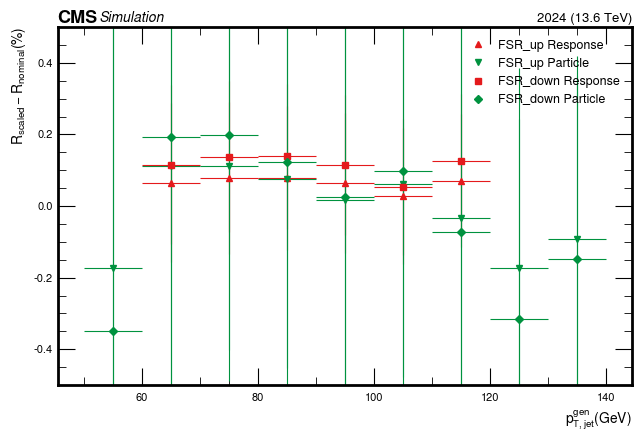

Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.
Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.
Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.


In [ ]:
# Plot with the FSR corrections tracker
plot = Plotting()

Intervals = np.linspace(50, 140, 10)

plot.Add_Histo_pt(df_b, "stnd", Intervals)
plot.Add_Histo_pt(df_b, "FSR_up", Intervals, weight="w_FSR_up")
plot.Add_Histo_pt(df_b, "FSR_down", Intervals, weight="w_FSR_down")

plot.subtract("FSR_up", "stnd")
plot.subtract("FSR_down", "stnd")

plot.Profile(["FSR_up", "FSR_down"], ["#e41a1c", "#377eb8"], (-0.5,0.5), r'$p^{gen}_{T,jet}(GeV)$', r'$R_{scaled} - R_{nominal}(\%)$')

/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_15218/4103682402.py:87: RuntimeWarning: invalid value encountered in divide
  value = 100*(val1 - val2) / val2
/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_15218/4103682402.py:92: RuntimeWarning: invalid value encountered in divide
  StndDev = np.sqrt(var1/val2**2 + var2*val1**2/val2**4)


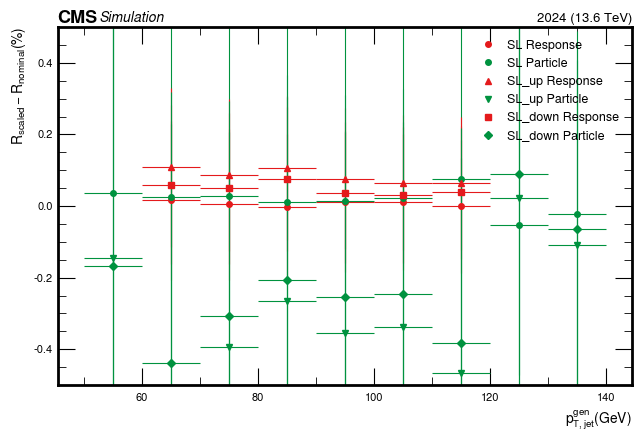

Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.
Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.
Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.
Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.


In [ ]:
# Plot with semileptonic corrections tracker
plot = Plotting()

Intervals = np.linspace(50, 140, 10)

plot.Add_Histo_pt(df_b, "stnd", Intervals)
plot.Add_Histo_pt(df_b, "SL", Intervals, weight="GenWeight_SL")
plot.Add_Histo_pt(df_b, "SL_up", Intervals, weight="GenWeight_SL_up")
plot.Add_Histo_pt(df_b, "SL_down", Intervals, weight="GenWeight_SL_down")

plot.subtract("SL", "stnd")
plot.subtract("SL_up", "stnd")
plot.subtract("SL_down", "stnd")

plot.Profile(["SL", "SL_up", "SL_down"], ["#e41a1c", "#377eb8"], (-0.5,0.5), r'$p^{gen}_{T,jet}(GeV)$', r'$R_{scaled} - R_{nominal}(\%)$')

/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_15218/4103682402.py:87: RuntimeWarning: invalid value encountered in divide
  value = 100*(val1 - val2) / val2
/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_15218/4103682402.py:92: RuntimeWarning: invalid value encountered in divide
  StndDev = np.sqrt(var1/val2**2 + var2*val1**2/val2**4)


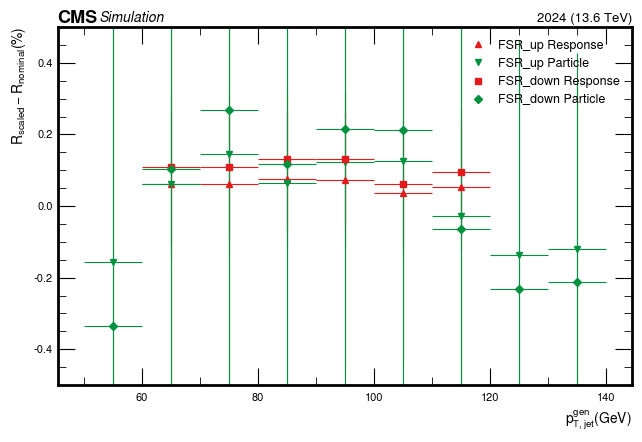

Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.
Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.
Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.


In [ ]:
# Plot with FSR corrections barrel
plot = Plotting()

Intervals = np.linspace(50, 140, 10)

plot.Add_Histo_pt(df_b_barrel, "stnd", Intervals)
plot.Add_Histo_pt(df_b_barrel, "FSR_up", Intervals, weight="w_FSR_up")
plot.Add_Histo_pt(df_b_barrel, "FSR_down", Intervals, weight="w_FSR_down")

plot.subtract("FSR_up", "stnd")
plot.subtract("FSR_down", "stnd")

plot.Profile(["FSR_up", "FSR_down"], ["#e41a1c", "#377eb8"], (-0.5,0.5), r'$p^{gen}_{T,jet}(GeV)$', r'$R_{scaled} - R_{nominal}(\%)$')

/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_15218/4103682402.py:87: RuntimeWarning: invalid value encountered in divide
  value = 100*(val1 - val2) / val2
/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_15218/4103682402.py:92: RuntimeWarning: invalid value encountered in divide
  StndDev = np.sqrt(var1/val2**2 + var2*val1**2/val2**4)


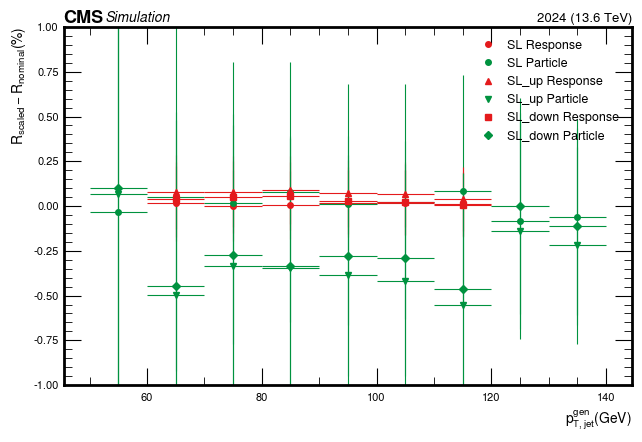

Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.
Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.
Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.
Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.


In [ ]:
# Plot with semileptonic corrections tracker
plot = Plotting()

Intervals = np.linspace(50, 140, 10)

plot.Add_Histo_pt(df_b_barrel, "stnd", Intervals)
plot.Add_Histo_pt(df_b_barrel, "SL", Intervals, weight="GenWeight_SL")
plot.Add_Histo_pt(df_b_barrel, "SL_up", Intervals, weight="GenWeight_SL_up")
plot.Add_Histo_pt(df_b_barrel, "SL_down", Intervals, weight="GenWeight_SL_down")

plot.subtract("SL", "stnd")
plot.subtract("SL_up", "stnd")
plot.subtract("SL_down", "stnd")

plot.Profile(["SL", "SL_up", "SL_down"], ["#e41a1c", "#377eb8", "#4daf4a"], (-1,1), r'$p^{gen}_{T,jet}(GeV)$', r'$R_{scaled} - R_{nominal}(\%)$')

/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_15218/4103682402.py:87: RuntimeWarning: invalid value encountered in divide
  value = 100*(val1 - val2) / val2
/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_15218/4103682402.py:92: RuntimeWarning: invalid value encountered in divide
  StndDev = np.sqrt(var1/val2**2 + var2*val1**2/val2**4)


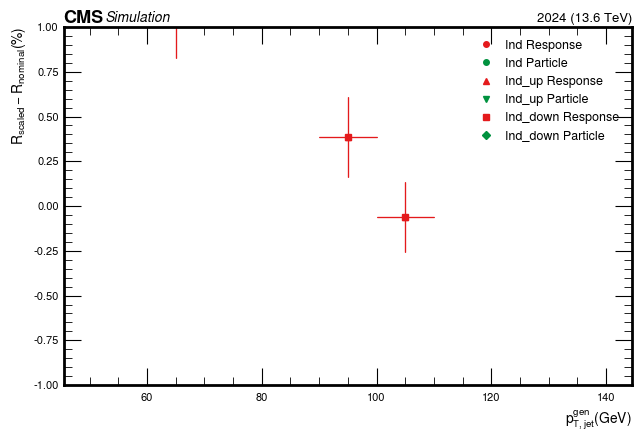

Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.
Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.
Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.
Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.


In [ ]:
# Individual corrections tracker
plot = Plotting()

Intervals = np.linspace(50, 140, 10)

plot.Add_Histo_pt(df_b, "stnd", Intervals)
plot.Add_Histo_pt(df_b, "Ind", Intervals, weight="GenWeight_Ind")
plot.Add_Histo_pt(df_b, "Ind_up", Intervals, weight="GenWeight_Ind_up")
plot.Add_Histo_pt(df_b, "Ind_down", Intervals, weight="GenWeight_Ind_down")

plot.subtract("Ind", "stnd")
plot.subtract("Ind_up", "stnd")
plot.subtract("Ind_down", "stnd")


plot.Profile(["Ind", "Ind_up", "Ind_down"], ["#e41a1c", "#377eb8"], (-1,1), r'$p^{gen}_{T,jet}(GeV)$', r'$R_{scaled} - R_{nominal}(\%)$')

/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_15218/4103682402.py:87: RuntimeWarning: invalid value encountered in divide
  value = 100*(val1 - val2) / val2
/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_15218/4103682402.py:92: RuntimeWarning: invalid value encountered in divide
  StndDev = np.sqrt(var1/val2**2 + var2*val1**2/val2**4)


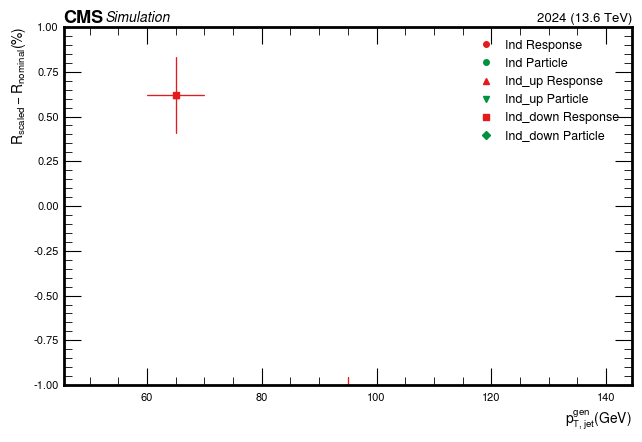

Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.
Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.
Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.
Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.


In [ ]:
# Individual corrections barrel
plot = Plotting()

Intervals = np.linspace(50, 140, 10)

plot.Add_Histo_pt(df_b_barrel, "stnd", Intervals)
plot.Add_Histo_pt(df_b_barrel, "Ind", Intervals, weight="GenWeight_Ind")
plot.Add_Histo_pt(df_b_barrel, "Ind_up", Intervals, weight="GenWeight_Ind_up")
plot.Add_Histo_pt(df_b_barrel, "Ind_down", Intervals, weight="GenWeight_Ind_down")

plot.subtract("Ind", "stnd")
plot.subtract("Ind_up", "stnd")
plot.subtract("Ind_down", "stnd")


plot.Profile(["Ind", "Ind_up", "Ind_down"], ["#e41a1c", "#377eb8", "#4daf4a"], (-1,1), r'$p^{gen}_{T,jet}(GeV)$', r'$R_{scaled} - R_{nominal}(\%)$')

In [ ]:
# Inclusive corrections tracker
plot = Plotting()

Intervals = np.linspace(50, 140, 10)

plot.Add_Histo_pt(df_b, "stnd", Intervals)
plot.Add_Histo_pt(df_b, "Inc", Intervals, weight="GenWeight_Inc")
plot.Add_Histo_pt(df_b, "Inc_up", Intervals, weight="GenWeight_Inc_up")
plot.Add_Histo_pt(df_b, "Inc_down", Intervals, weight="GenWeight_Inc_down")

plot.subtract("Inc", "stnd")
plot.subtract("Inc_up", "stnd")
plot.subtract("Inc_down", "stnd")


plot.Profile(["Inc", "Inc_up", "Inc_down"], ["#e41a1c", "#377eb8", "#4daf4a"], (-0.5,0.5), r'$p^{gen}_{T,jet}(GeV)$', r'$R_{scaled} - R_{nominal}(\%)$')

KeyboardInterrupt: 

Warning in <RunGraphs>: Got 9 handles from which 9 link to results which are already ready.


In [ ]:
# Inclusive corrections tracker
plot = Plotting()

Intervals = np.linspace(50, 140, 10)

plot.Add_Histo_pt(df_b_barrel, "stnd", Intervals)
plot.Add_Histo_pt(df_b_barrel, "Inc", Intervals, weight="GenWeight_Inc")
plot.Add_Histo_pt(df_b_barrel, "Inc_up", Intervals, weight="GenWeight_Inc_up")
plot.Add_Histo_pt(df_b_barrel, "Inc_down", Intervals, weight="GenWeight_Inc_down")

plot.subtract("Inc", "stnd")
plot.subtract("Inc_up", "stnd")
plot.subtract("Inc_down", "stnd")


plot.Profile(["Inc", "Inc_up", "Inc_down"], ["#e41a1c", "#377eb8", "#4daf4a"], (-0.5,0.5), r'$p^{gen}_{T,jet}(GeV)$', r'$R_{scaled} - R_{nominal}(\%)$')